In [2]:
import tables as tb
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re
import math as mt
from scipy.stats import norm
import scipy
import seaborn as sns
from astropy.table import Table, vstack
import glob
from datetime import datetime
from python_modules.muonpipe import usefull_func
import glob
OPT_EFF=[0.6, 0.7, 0.8, 0.9, 1.0]
MIR_MIS=[0.00125, 0.0025, 0.0035, 0.005, 0.0075, 0.01, 0.0125]
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

size_outside = 500 # phe



### Recent tries of datacheck processing

In [4]:
files = glob.glob('/Users/vdk/muons2024/v0.9-v0.10/20*/DL1_datacheck_*.h5')
files.sort()

runsummary = []
cosmics = []
for file in files:
    runsummary.append(pd.read_hdf(file, 'runsummary'))
    cosmics.append(pd.read_hdf(file, 'cosmics'))
    
cosmics_pd = pd.concat(cosmics, ignore_index=True)
runsummary_pd = pd.concat(runsummary, ignore_index=True)
cosmics_pd.columns

Index(['runnumber', 'subrun', 'time', 'elapsed_time', 'events', 'azimuth',
       'altitude', 'wrong_ucts_trig_type', 'wrong_tib_trig_type',
       'unknown_ucts_trig_type', 'unknown_tib_trig_type', 'num_ucts_jumps',
       'num_contained_mu_rings', 'mu_effi_mean', 'mu_effi_stddev',
       'mu_width_mean', 'mu_width_stddev', 'mu_radius_mean',
       'mu_radius_stddev', 'mu_intensity_mean', 'mu_hg_peak_sample',
       'mu_hg_peak_sample_stddev', 'fraction_pulses_above10',
       'fraction_pulses_above30'],
      dtype='object')

In [5]:
runsummary_pd.columns

Index(['runnumber', 'time', 'elapsed_time', 'min_altitude', 'mean_altitude',
       'max_altitude', 'min_azimuth', 'max_azimuth', 'mean_azimuth', 'mean_ra',
       'mean_dec', 'num_cosmics', 'num_pedestals', 'num_flatfield',
       'num_unknown_ucts_trigger_tags', 'num_wrong_ucts_tags_in_cosmics',
       'num_wrong_ucts_tags_in_pedestals', 'num_wrong_ucts_tags_in_flatfield',
       'num_ucts_jumps', 'num_unknown_tib_trigger_tags',
       'num_wrong_tib_tags_in_cosmics', 'num_wrong_tib_tags_in_pedestals',
       'num_wrong_tib_tags_in_flatfield', 'num_pedestals_after_cleaning',
       'num_contained_mu_rings', 'ff_charge_mean', 'ff_charge_mean_err',
       'ff_charge_stddev', 'ff_time_mean', 'ff_time_mean_err',
       'ff_time_stddev', 'ff_rel_time_stddev', 'ped_charge_mean',
       'ped_charge_mean_err', 'ped_charge_stddev',
       'ped_fraction_pulses_above10', 'ped_fraction_pulses_above30',
       'cosmics_fraction_pulses_above10', 'cosmics_fraction_pulses_above30',
       'mu_effi_m

In [8]:
runs_with_0_rings = []
# Lets try to check if all subruns have muon rings
for run, num_rings in zip(cosmics_pd['runnumber'], cosmics_pd['num_contained_mu_rings']):
    if num_rings == 0:
        runs_with_0_rings.append(run)
        #print(run)

In [23]:
runsummary_pd[runsummary_pd['runnumber'].isin([16449])]

,runnumber,time,elapsed_time,min_altitude,mean_altitude,max_altitude,min_azimuth,max_azimuth,mean_azimuth,mean_ra,...,cosmics_fraction_pulses_above10,cosmics_fraction_pulses_above30,mu_effi_mean,mu_effi_stddev,mu_width_mean,mu_width_stddev,mu_hg_peak_sample_mean,mu_hg_peak_sample_stddev,mu_intensity_mean,mean_number_of_pixels_nearby_stars
7581,16449,1.706737e+09,1186.255663,0.899354,0.936896,0.973824,1.705903,1.764162,1.73452,114.942323,...,0.004295,0.000755,0.158115,0.013223,0.068096,0.020603,12.799771,1.527791,1987.13501,69.519685


In [4]:
# Lets choose only values with zenith anlge that differs not much than 1 degree
def delta(a,b):
    return abs(np.rad2deg(a)-np.rad2deg(b))

#runsummary_pd['runnumber'][(np.degrees(runsummary_pd['_altitude']) > 44) & (np.degrees(runsummary_pd['mean_altitude']) < 45)]) #& (runsummary_pd['mu_radius_mean'] > 0.95) & (runsummary_pd['mu_radius_mean'] < 1.3)]
zd_runnumbers = runsummary_pd['runnumber'][
    (delta(runsummary_pd['min_altitude'],runsummary_pd['max_altitude'])< 1) & 
    (delta(runsummary_pd['min_azimuth'],runsummary_pd['max_azimuth'])< 1) & 
    (runsummary_pd['mu_effi_stddev']<=0.02) & 
    (runsummary_pd['mu_width_stddev']<0.02) &
    (runsummary_pd['num_contained_mu_rings'])
]
zenith_table = runsummary_pd[runsummary_pd['runnumber'].isin(zd_runnumbers)]

In [5]:
zenith_table

,runnumber,time,elapsed_time,min_altitude,mean_altitude,max_altitude,min_azimuth,max_azimuth,mean_azimuth,mean_ra,...,cosmics_fraction_pulses_above10,cosmics_fraction_pulses_above30,mu_effi_mean,mu_effi_stddev,mu_width_mean,mu_width_stddev,mu_hg_peak_sample_mean,mu_hg_peak_sample_stddev,mu_intensity_mean,mean_number_of_pixels_nearby_stars
18,1649,1.574814e+09,67.083244,1.093454,1.095815,1.097694,1.707341,1.710794,1.709262,83.727030,...,0.011573,0.002779,0.187329,0.015422,0.065652,0.019412,12.796117,1.909459,2353.212646,180.333333
29,1792,1.579123e+09,244.938722,0.928062,0.931323,0.934556,0.428313,0.438660,0.433499,83.286474,...,0.002866,0.000461,0.184386,0.015131,0.062220,0.019020,14.745975,3.776443,2384.742920,50.750000
31,1794,1.579124e+09,332.241263,0.972077,0.975644,0.979069,0.337438,0.354710,0.346031,83.300907,...,0.009720,0.001658,0.184603,0.016270,0.061785,0.019590,15.239130,3.851621,2372.605957,47.304348
101,1969,1.581636e+09,31.304596,1.063869,1.064558,1.065320,4.603975,4.605069,4.604547,83.641555,...,0.004979,0.000870,0.177148,0.016844,0.065914,0.019579,14.103448,2.407883,2161.871826,189.000000
167,2203,1.594683e+09,581.398078,0.845655,0.849568,0.852667,0.330545,0.343756,0.336680,299.370161,...,0.003925,0.000664,0.159713,0.014394,0.063934,0.019877,17.472624,2.375099,2003.729980,95.815385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7838,16737,1.707786e+09,154.040303,0.686284,0.690695,0.695215,4.806488,4.810739,4.808666,83.295649,...,0.030168,0.001133,0.157941,0.014985,0.065010,0.019208,16.182768,1.266985,1983.829468,140.444444
7839,16738,1.707786e+09,35.408176,1.152846,1.153494,1.154142,1.049471,1.050329,1.049899,166.624753,...,0.004398,0.000667,0.160177,0.013002,0.067092,0.016996,15.911765,1.393784,1986.556396,69.200000
7842,16741,1.707789e+09,27.242857,0.928167,0.928765,0.929380,4.554875,4.555748,4.555326,114.959243,...,0.004407,0.000806,0.158413,0.011175,0.063558,0.018844,15.125000,0.875162,2012.271362,73.000000
7845,16744,1.707791e+09,41.721298,1.032892,1.033864,1.034824,1.287021,1.287165,1.287091,197.612563,...,0.004306,0.000787,0.160541,0.011259,0.069316,0.017539,16.495495,1.052045,1956.444946,9.000000


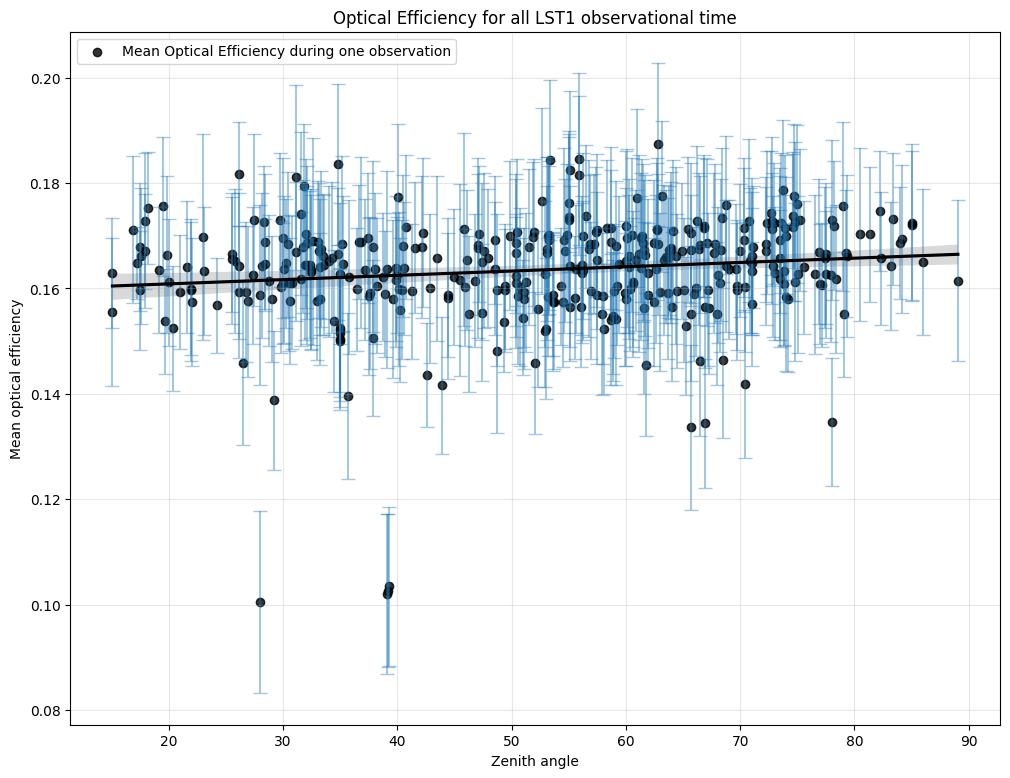

In [108]:
plt.figure(figsize = (12,9))
sns.regplot(x = np.degrees(zenith_table['mean_altitude']), y = zenith_table['mu_effi_mean'], color = 'k', label = 'Mean Optical Efficiency during one observation')#, x_bins=75
plt.errorbar(np.degrees(zenith_table['mean_altitude']), zenith_table['mu_effi_mean'], yerr=zenith_table['mu_effi_stddev'], fmt = 'none', capsize=5, zorder=1, color='C0', alpha = 0.4)
plt.grid(alpha = 0.3)
plt.title("Optical Efficiency for all LST1 observational time")
#plt.vlines(3000,0,0.3)
#plt.ylim(0.1,0.275)
# plt.fill_betweenx(y=[0,0.3], x1 = 0, x2=x_fill[1], alpha = 0.05)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[1], x2=x_fill[2], alpha = 0.075)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[2], x2=x_fill[3], alpha = 0.075)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[3], x2=x_fill[4], alpha = 0.075)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[4], x2=x_fill[5], alpha = 0.075)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[5], x2=18000, alpha = 0.075)
#plt.xlim(0,18000)
plt.xlabel('Zenith angle')
plt.ylabel('Mean optical efficiency')
plt.legend()

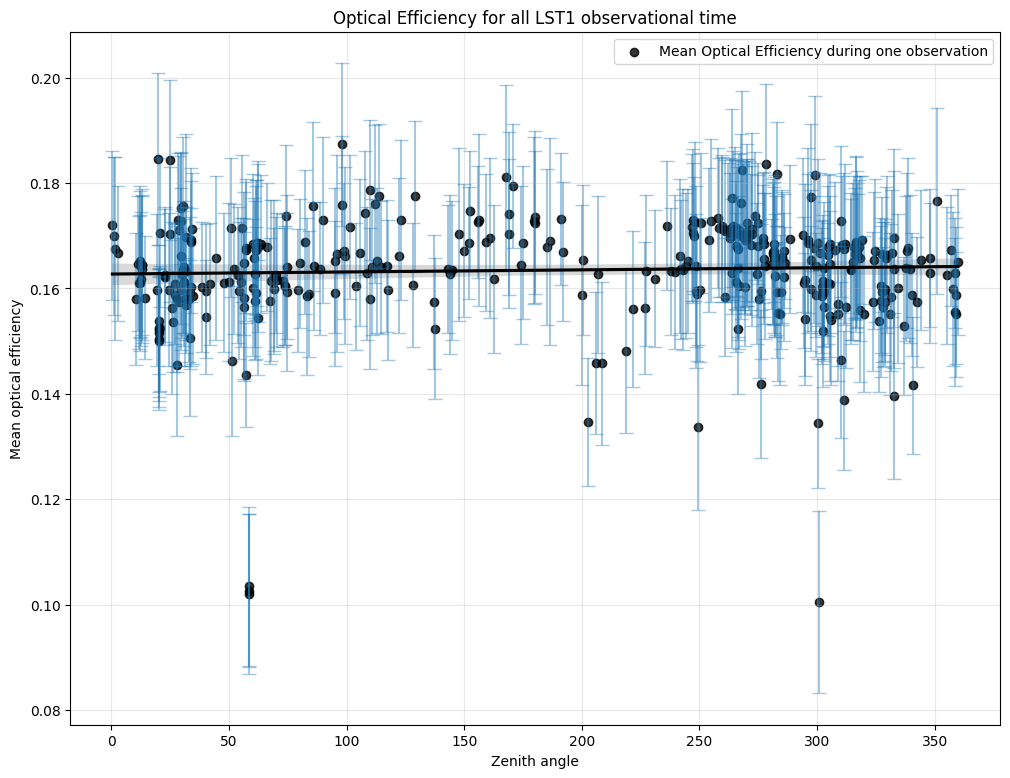

In [110]:
plt.figure(figsize = (12,9))
sns.regplot(x = np.degrees(zenith_table['mean_azimuth']), y = zenith_table['mu_effi_mean'], color = 'k', label = 'Mean Optical Efficiency during one observation')#, x_bins=75
plt.errorbar(np.degrees(zenith_table['mean_azimuth']), zenith_table['mu_effi_mean'], yerr=zenith_table['mu_effi_stddev'], fmt = 'none', capsize=5, zorder=1, color='C0', alpha = 0.4)
#plt.errorbar(mean_runs, mean_opt_efficiency, yerr=std_opt, fmt = 'none', capsize=5, zorder=1, color='C0', alpha = 0.4)
plt.grid(alpha = 0.3)
plt.title("Optical Efficiency for all LST1 observational time")
#plt.vlines(3000,0,0.3)
#plt.ylim(0.1,0.275)
# plt.fill_betweenx(y=[0,0.3], x1 = 0, x2=x_fill[1], alpha = 0.05)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[1], x2=x_fill[2], alpha = 0.075)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[2], x2=x_fill[3], alpha = 0.075)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[3], x2=x_fill[4], alpha = 0.075)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[4], x2=x_fill[5], alpha = 0.075)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[5], x2=18000, alpha = 0.075)
#plt.xlim(0,18000)
plt.xlabel('Zenith angle')
plt.ylabel('Mean optical efficiency')
plt.legend()

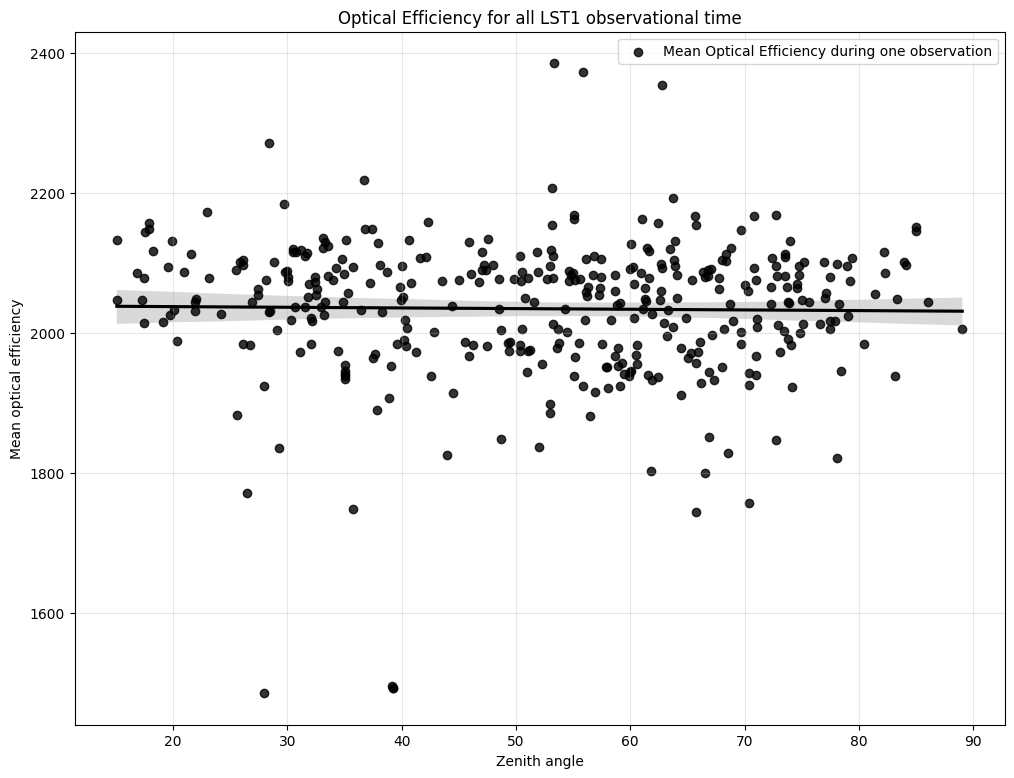

In [115]:
plt.figure(figsize = (12,9))
sns.regplot(x = np.degrees(zenith_table['mean_altitude']), y = zenith_table['mu_intensity_mean'], color = 'k', label = 'Mean Optical Efficiency during one observation')#, x_bins=75
#plt.errorbar(np.degrees(zenith_table['mean_altitude']), zenith_table['mu_effi_mean'], yerr=zenith_table['mu_effi_stddev'], fmt = 'none', capsize=5, zorder=1, color='C0', alpha = 0.4)
plt.grid(alpha = 0.3)
plt.title("Optical Efficiency for all LST1 observational time")
#plt.vlines(3000,0,0.3)
#plt.ylim(0.1,0.275)
# plt.fill_betweenx(y=[0,0.3], x1 = 0, x2=x_fill[1], alpha = 0.05)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[1], x2=x_fill[2], alpha = 0.075)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[2], x2=x_fill[3], alpha = 0.075)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[3], x2=x_fill[4], alpha = 0.075)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[4], x2=x_fill[5], alpha = 0.075)
# plt.fill_betweenx(y=[0,0.3], x1 = x_fill[5], x2=18000, alpha = 0.075)
#plt.xlim(0,18000)
plt.xlabel('Zenith angle')
plt.ylabel('Mean optical efficiency')
plt.legend()

(0.0, 0.02)

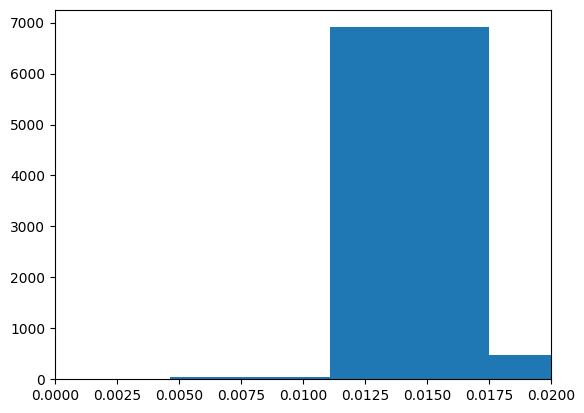

In [93]:
z,x,c = plt.hist(runsummary_pd['mu_effi_stddev'], bins = 50)
plt.xlim(0,0.02)

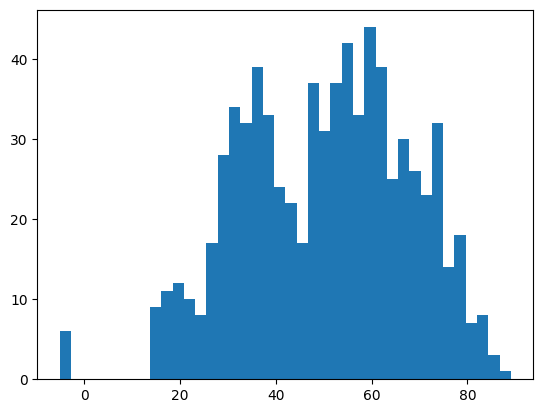

In [79]:
z,x,c = plt.hist(np.degrees(zenith_table['mean_altitude']), bins = 40)


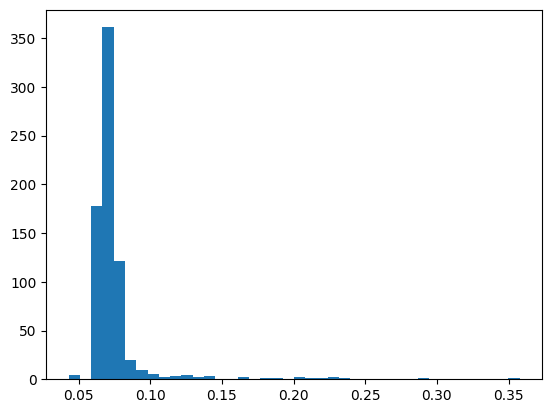

In [80]:
z,x,c = plt.hist(zenith_table['mu_width_mean'], bins = 40)

(0.0, 5000.0)

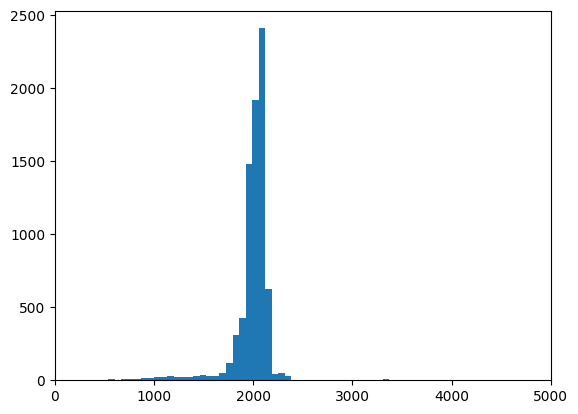

In [20]:
z,x,c = plt.hist(runsummary_pd['mu_intensity_mean'],bins = 50)
plt.xlim(0,5000)

0.8024780647938808

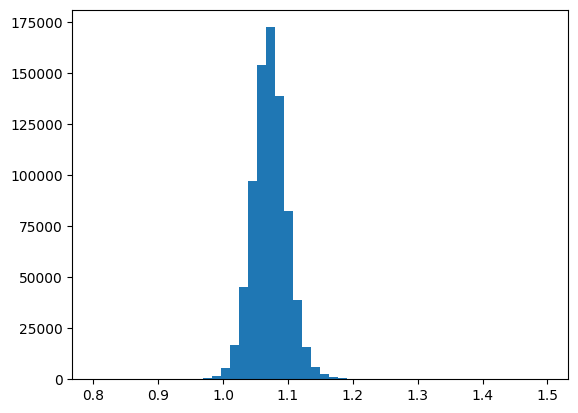

In [19]:
z,x,c = plt.hist(cosmics_pd['mu_radius_mean'],bins = 50)
min(cosmics_pd['mu_radius_mean'])

### Looking for other quality cuts

In [6]:
runsummary_pd['elapsed_time']

0       1479.185384
1       1492.465697
2        877.161720
3       1822.499924
4        922.360651
           ...     
7946     888.711240
7947     164.343513
7948    1189.534480
7949    1181.681148
7950    1178.440647
Name: elapsed_time, Length: 7951, dtype: float64

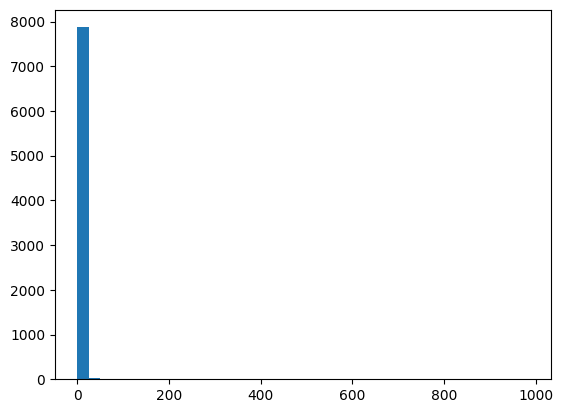

In [10]:
z,x,c = plt.hist(runsummary_pd['cosmics_fraction_pulses_above30']*runsummary_pd['elapsed_time'], bins = 40)

### Rubens code

In [2]:
date=20200114

listdir = glob.glob('/Users/vdk/muons2024/20240131muons/muons_LST-1.Run*')
# Muons analyzed using GlobalPeakWindowSum

dat = Table.read('{}'.format(listdir[0]), format='fits')
for i in range(1,len(listdir)):
    dat2 = Table.read('{}'.format(listdir[i]), format='fits')
    dat = vstack([dat, dat2])

df = dat.to_pandas()
df_good_data = df[df['good_ring']]

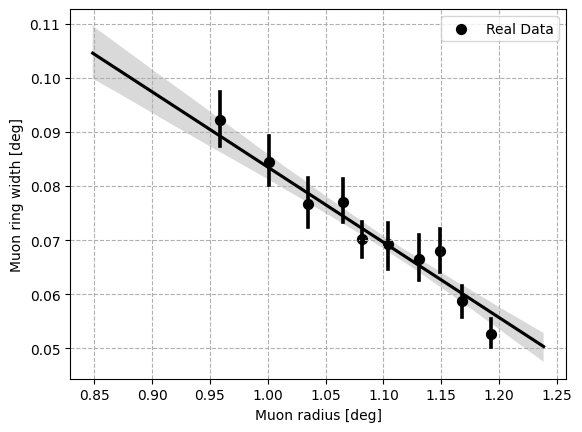

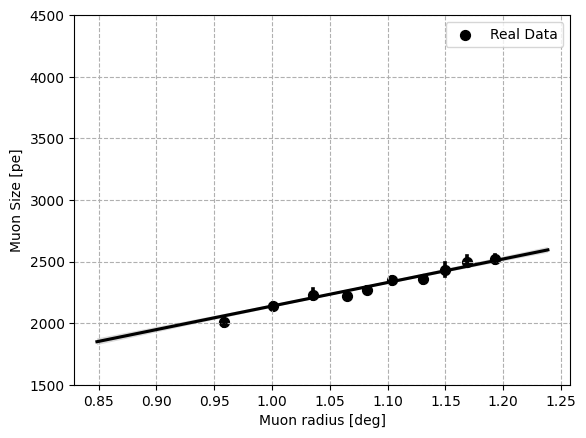

In [3]:
def format_axes(ax,option):
    
    if(option=='width'):
        ax.set_xlabel('Muon radius [deg]')
        ax.set_ylabel('Muon ring width [deg]')
        ax.grid(linestyle="dashed")
        #ax.set_ylim(0.042,0.07)
        ax.legend()
    if(option=='size'):
        ax2.grid(linestyle="dashed")
        ax2.legend(ncol=2)
        ax2.set_xlabel('Muon radius [deg]')
        ax2.set_ylabel('Muon Size [pe]')
        ax2.set_ylim(1500,4500)
        
fig,ax = plt.subplots()
fig2,ax2 = plt.subplots()



sns.regplot(x = df_good_data['ring_radius'][(df_good_data['ring_completeness'] > 0.9) & (df_good_data['size_outside'] < size_outside)], 
            y = df_good_data['ring_width'][(df_good_data['ring_completeness'] > 0.9) & (df_good_data['size_outside'] < size_outside)], 
            x_bins=10, ax=ax, color = 'k', label = 'Real Data')
sns.regplot(x = df_good_data['ring_radius'][(df_good_data['ring_completeness'] > 0.9) & (df_good_data['size_outside'] < size_outside)], 
            y = df_good_data['ring_size'][(df_good_data['ring_completeness'] > 0.9) & (df_good_data['size_outside'] < size_outside)], 
            x_bins=10, ax=ax2, color = 'k', label = 'Real Data')

format_axes(ax,'width')        
format_axes(ax2,'size') 

In [4]:
def Calculate_stereo_rate(RingComp,RINGCOMPCUT,RingCont,RINGCONTCUT,ImpactDiff,IMPACTDIFFCUT):   
    """
    RingComp - completeness
    RingCont - containment
    ImpactDiff - difference in sim and rec impact parameter
    RINGCOMPCUT,RINGCONTCUT,IMPACTDIFFCUT - cuts on the appropriate variables
    """ 
    VIEWANGLE = 3.5 # deg
    IMPACT_PARAMETER = 150 # m
    Flux = 200 # m^-2 s^-1 sr^-1

    Solid_angle = 2 * mt.pi * (1 - mt.cos(np.radians(3.5)))
    Area = mt.pi * mt.pow(IMPACT_PARAMETER,2)
    Nsim = 1e7
    Nrec = len(RingCont[(RingComp > RINGCOMPCUT) & 
                        (RingCont > RINGCONTCUT) & 
                        (ImpactDiff < IMPACTDIFFCUT)])
    print("Nrec = ", Nrec)
    rate = Flux * Solid_angle * Area * Nrec / Nsim  # Hz
    erate = Flux * Solid_angle * Area * mt.sqrt(Nrec) / Nsim # Hz
    print("Number of seconds simulated: ", Nsim / (Flux * Solid_angle * Area) )
    
    return rate, erate

In [5]:
#maindir='../../../cta-lstchain-extra/muons/simulations/lstchain_v0/Stereo/Array_centered/'

RINGCOMPCUT = 0.9 # containment of pixels above threshold inside a ring
RINGCONTCUT = 0.9 # Angular cut for muon containment within the camera
IMPACTDIFFCUT = 10. # Difference between reconstructed and real Impact parameter

#sfn = sorted(os.listdir(maindir + 'files')) # Sort the filename list

maindir = '/Users/vdk/muons2024/20240131muons/'
sfn = os.listdir('/Users/vdk/muons2024/20240131muons/')

RingWidth = []
MuonEff = []
ImpactParam = []
RingCont = []
RingComp = []
RingPixComp = []
Core_x = []
Core_y = []
Impact_arr_x = []
Impact_arr_y = []
MCImpactP = []
ImpactDiff = []
RingSize = []
RingRadius = []
NTels = []

for filename in sfn:
    if filename.endswith(".fits"):
        #print("Opening file: ", filename)
        table=fits.open("%s/%s" % (maindir,filename))
        data=table[1].data
        
        MuonEff = np.concatenate([MuonEff,data.field(0)])
        RingWidth = np.concatenate([RingWidth,data.field(2)])
        ImpactParam = np.concatenate([ImpactParam,data.field(1)])
        RingCont = np.concatenate([RingCont,data.field(3)])
        RingComp = np.concatenate([RingComp,data.field(4)])
        RingPixComp = np.concatenate([RingPixComp,data.field(5)])
        Core_x = np.concatenate([Core_x,data.field(6)])
        Core_y = np.concatenate([Core_y,data.field(7)])
        Impact_arr_x = np.concatenate([Impact_arr_x,data.field(8)])
        Impact_arr_y = np.concatenate([Impact_arr_y,data.field(9)])
        MCImpactP = np.concatenate([MCImpactP,data.field(10)])
        ImpactDiff = np.concatenate([ImpactDiff,data.field(11)])
        RingSize = np.concatenate([RingSize,data.field(12)])
        RingRadius = np.concatenate([RingRadius,data.field(13)])
        NTels = np.concatenate([NTels,data.field(14)])

rate, erate = Calculate_stereo_rate(RingPixComp, -1, RingCont, -1, ImpactDiff, 1e10)
print("The rate of muons is %.1f+-%.1f Hz" % (rate, erate))

rate, erate = Calculate_stereo_rate(RingPixComp, -1, RingCont, -1, ImpactDiff, IMPACTDIFFCUT)
print("The rate of well reconstructed muons (< %i m) containment is %.1f+-%.1f Hz" % (IMPACTDIFFCUT, rate, erate))

rate, erate = Calculate_stereo_rate(RingPixComp, RINGCOMPCUT, RingCont, -1, ImpactDiff, 1e10)
print("The rate of well reconstructed muons (> %i%%) pixel ring containment is %.1f+-%.1f Hz" % (RINGCOMPCUT*100, rate, erate))

rate, erate = Calculate_stereo_rate(RingComp, RINGCOMPCUT, RingCont, -1, ImpactDiff, 1e10)
print("The rate of well reconstructed muons (> %i%%) ring completeness is %.1f+-%.1f Hz" % (RINGCOMPCUT*100, rate, erate))

rate, erate = Calculate_stereo_rate(RingPixComp, -1, RingCont, RINGCONTCUT, ImpactDiff, 1e10)
print("The rate of well reconstructed muons (> %i%%) ring containment is %.1f+-%.1f Hz" % (RINGCONTCUT*100, rate, erate))

rate, erate = Calculate_stereo_rate(RingPixComp, RINGCOMPCUT, RingCont, RINGCONTCUT, ImpactDiff, IMPACTDIFFCUT)
print("The rate of well reconstructed muons all cuts is %.1f+-%.1f Hz" % (rate, erate))

Nrec =  61170
Number of seconds simulated:  60.3576011599849
The rate of muons is 1013.5+-4.1 Hz
Nrec =  61170
Number of seconds simulated:  60.3576011599849
The rate of well reconstructed muons (< 10 m) containment is 1013.5+-4.1 Hz
Nrec =  14210
Number of seconds simulated:  60.3576011599849
The rate of well reconstructed muons (> 90%) pixel ring containment is 235.4+-2.0 Hz
Nrec =  7700
Number of seconds simulated:  60.3576011599849
The rate of well reconstructed muons (> 90%) ring completeness is 127.6+-1.5 Hz
Nrec =  61170
Number of seconds simulated:  60.3576011599849
The rate of well reconstructed muons (> 90%) ring containment is 1013.5+-4.1 Hz
Nrec =  14210
Number of seconds simulated:  60.3576011599849
The rate of well reconstructed muons all cuts is 235.4+-2.0 Hz


### Datacheck hdf5 processing

In [7]:
# Path to your HDF5 file
dl1_file = '/Users/vdk/muons2024/DL1_datacheck_20240131.h5'

fi = h5py.File(dl1_file, 'r')
keys = list(fi.keys())

def printname(name):
    print(name)

# Show all included tables
fi.visit(printname)
pd_hdf = pd.read_hdf(dl1_file, 'runsummary/table')
pd_hdf_cosmics = pd.read_hdf(dl1_file, 'cosmics/table')
pd_hdf.columns


cosmics
cosmics/_i_table
cosmics/_i_table/altitude
cosmics/_i_table/altitude/abounds
cosmics/_i_table/altitude/bounds
cosmics/_i_table/altitude/indices
cosmics/_i_table/altitude/indicesLR
cosmics/_i_table/altitude/mbounds
cosmics/_i_table/altitude/mranges
cosmics/_i_table/altitude/ranges
cosmics/_i_table/altitude/sorted
cosmics/_i_table/altitude/sortedLR
cosmics/_i_table/altitude/zbounds
cosmics/_i_table/azimuth
cosmics/_i_table/azimuth/abounds
cosmics/_i_table/azimuth/bounds
cosmics/_i_table/azimuth/indices
cosmics/_i_table/azimuth/indicesLR
cosmics/_i_table/azimuth/mbounds
cosmics/_i_table/azimuth/mranges
cosmics/_i_table/azimuth/ranges
cosmics/_i_table/azimuth/sorted
cosmics/_i_table/azimuth/sortedLR
cosmics/_i_table/azimuth/zbounds
cosmics/_i_table/elapsed_time
cosmics/_i_table/elapsed_time/abounds
cosmics/_i_table/elapsed_time/bounds
cosmics/_i_table/elapsed_time/indices
cosmics/_i_table/elapsed_time/indicesLR
cosmics/_i_table/elapsed_time/mbounds
cosmics/_i_table/elapsed_time/mra

Index(['index', 'runnumber', 'time', 'elapsed_time', 'min_altitude',
       'mean_altitude', 'max_altitude', 'min_azimuth', 'max_azimuth',
       'mean_azimuth', 'mean_ra', 'mean_dec', 'num_cosmics', 'num_pedestals',
       'num_flatfield', 'num_unknown_ucts_trigger_tags',
       'num_wrong_ucts_tags_in_cosmics', 'num_wrong_ucts_tags_in_pedestals',
       'num_wrong_ucts_tags_in_flatfield', 'num_ucts_jumps',
       'num_unknown_tib_trigger_tags', 'num_wrong_tib_tags_in_cosmics',
       'num_wrong_tib_tags_in_pedestals', 'num_wrong_tib_tags_in_flatfield',
       'num_pedestals_after_cleaning', 'num_contained_mu_rings',
       'ff_charge_mean', 'ff_charge_mean_err', 'ff_charge_stddev',
       'ff_time_mean', 'ff_time_mean_err', 'ff_time_stddev',
       'ff_rel_time_stddev', 'ped_charge_mean', 'ped_charge_mean_err',
       'ped_charge_stddev', 'ped_fraction_pulses_above10',
       'ped_fraction_pulses_above30', 'cosmics_fraction_pulses_above10',
       'cosmics_fraction_pulses_above30', '

In [51]:
for column in pd_hdf.columns:
    print(column)

index
runnumber
time
elapsed_time
min_altitude
mean_altitude
max_altitude
min_azimuth
max_azimuth
mean_azimuth
mean_ra
mean_dec
num_cosmics
num_pedestals
num_flatfield
num_unknown_ucts_trigger_tags
num_wrong_ucts_tags_in_cosmics
num_wrong_ucts_tags_in_pedestals
num_wrong_ucts_tags_in_flatfield
num_ucts_jumps
num_unknown_tib_trigger_tags
num_wrong_tib_tags_in_cosmics
num_wrong_tib_tags_in_pedestals
num_wrong_tib_tags_in_flatfield
num_pedestals_after_cleaning
num_contained_mu_rings
ff_charge_mean
ff_charge_mean_err
ff_charge_stddev
ff_time_mean
ff_time_mean_err
ff_time_stddev
ff_rel_time_stddev
ped_charge_mean
ped_charge_mean_err
ped_charge_stddev
ped_fraction_pulses_above10
ped_fraction_pulses_above30
cosmics_fraction_pulses_above10
cosmics_fraction_pulses_above30
mu_effi_mean
mu_effi_stddev
mu_width_mean
mu_width_stddev
mu_hg_peak_sample_mean
mu_hg_peak_sample_stddev
mu_intensity_mean
mean_number_of_pixels_nearby_stars


In [53]:
for column in pd_hdf_cosmics.columns:
    print(column)

index
runnumber
subrun
time
elapsed_time
events
azimuth
altitude
wrong_ucts_trig_type
wrong_tib_trig_type
unknown_ucts_trig_type
unknown_tib_trig_type
num_ucts_jumps
num_contained_mu_rings
mu_effi_mean
mu_effi_stddev
mu_width_mean
mu_width_stddev
mu_radius_mean
mu_radius_stddev
mu_intensity_mean
mu_hg_peak_sample
mu_hg_peak_sample_stddev
fraction_pulses_above10
fraction_pulses_above30


In [54]:
for item in pd_hdf_cosmics['mu_intensity_mean']:

1984.8154296875
1927.5635986328125
2185.70458984375
1925.992431640625
1970.002197265625
2128.18896484375
2073.83837890625
1947.8446044921875
2094.170654296875
2016.2960205078125
2032.70361328125
2003.290283203125
1985.601806640625
1966.7786865234375
2013.43603515625
2094.49755859375
1955.496337890625
1925.18359375
1964.7403564453125
1970.6572265625
1951.073486328125
2043.9638671875
2196.14697265625
2015.6510009765625
1976.9586181640625
1932.5147705078125
1969.30078125
1889.4219970703125
2104.73095703125
1989.580810546875
1918.39990234375
1907.769287109375
1990.11572265625
2082.165771484375
1968.3798828125
2012.02783203125
1970.1263427734375
1992.4365234375
1933.874267578125
1965.6982421875
2029.4368896484375
2008.9871826171875
1910.7745361328125
1944.4703369140625
2002.61962890625
2036.02783203125
1981.93212890625
1962.611328125
2034.152587890625
1977.562744140625
1945.22119140625
2072.86962890625
1953.4951171875
2007.3360595703125
2050.8408203125
1974.3907470703125
1955.7423095703125


In [ ]:
for item in fi['runsummary/table']:
    print(item)

(0, 16445, 1.70673312e+09, 1189.92598963, 0.95296868, 0.97566424, 0.99744209, 3.70287806, 3.83491659, 3.77094605, 41.07502079, -0.00596619, 7219873, 107636, 107199, 0, 0., 0., 0., 0, 7434708, 0., 0., 0., 34, 3296, 71.86973014, 0.02761539, 9.83411266, 16.94229235, 0.00164199, 1.05408286, 0.39982527, 2.09317223, 0.00303289, 1.66759429, 0.00050435, 5.66780071e-08, 0.00430527, 0.0007536, 0.15771623, 0.01396439, 0.06849872, 0.01960821, 11.42718447, 1.72146356, 1985.8788, 51.888)
(1, 16446, 1.70673432e+09, 1181.15100503, 0.89156877, 0.91834995, 0.94481264, 3.85697072, 3.96902699, 3.9142789, 40.27689553, -0.00540262, 7085264, 112505, 112055, 0, 0., 0., 0., 0, 7309824, 0., 0., 0., 33, 3445, 71.47483934, 0.02912885, 9.80040242, 16.85892037, 0.00148737, 1.01151928, 0.39972811, 2.07598097, 0.00297764, 1.65461772, 0.00046823, 9.8626989e-08, 0.00432578, 0.00077168, 0.15655794, 0.0127491, 0.06738924, 0.01974418, 11.97271408, 1.47643463, 1977.3073, 52.56910569)
(2, 16447, 1.70673552e+09, 1180.4264655

Index(['index', 'runnumber', 'time', 'elapsed_time', 'min_altitude',
       'mean_altitude', 'max_altitude', 'min_azimuth', 'max_azimuth',
       'mean_azimuth', 'mean_ra', 'mean_dec', 'num_cosmics', 'num_pedestals',
       'num_flatfield', 'num_unknown_ucts_trigger_tags',
       'num_wrong_ucts_tags_in_cosmics', 'num_wrong_ucts_tags_in_pedestals',
       'num_wrong_ucts_tags_in_flatfield', 'num_ucts_jumps',
       'num_unknown_tib_trigger_tags', 'num_wrong_tib_tags_in_cosmics',
       'num_wrong_tib_tags_in_pedestals', 'num_wrong_tib_tags_in_flatfield',
       'num_pedestals_after_cleaning', 'num_contained_mu_rings',
       'ff_charge_mean', 'ff_charge_mean_err', 'ff_charge_stddev',
       'ff_time_mean', 'ff_time_mean_err', 'ff_time_stddev',
       'ff_rel_time_stddev', 'ped_charge_mean', 'ped_charge_mean_err',
       'ped_charge_stddev', 'ped_fraction_pulses_above10',
       'ped_fraction_pulses_above30', 'cosmics_fraction_pulses_above10',
       'cosmics_fraction_pulses_above30', '

### Lets choose only runs where change in telescope pointing direction does not exceed 1 deg

In [7]:

# Specify the directory you want to start from
#root_dir = '/Users/vdk/muons2024/datacheck_v0.10/'
root_dir = '/Users/vdk/muons2024/v0.9'

# Pattern to match all items in root_dir that are directories
pattern = os.path.join(root_dir, '*/')
run_numbers= {}

for dir_path in glob.glob(pattern):
    if dir_path[-5:-3] in ['11','12', '01', '02','03', '04']:
        dl1_file = dir_path+f'DL1_datacheck_{dir_path[-9:-1]}.h5'
        print(f"reading {dl1_file}")
        pd_hdf = pd.read_hdf(dl1_file, 'runsummary/table')
        for i,item in enumerate(pd_hdf['mean_altitude']):
            if (np.rad2deg(abs(pd_hdf['min_altitude'][i] - pd_hdf['max_altitude'][i])) <= 1) and \
               (np.rad2deg(abs(pd_hdf['min_azimuth'][i] - pd_hdf['max_azimuth'][i])) <= 1):
                run_numbers[pd_hdf['runnumber'][i]] = f"{np.rad2deg(pd_hdf['mean_altitude'][i])},{np.rad2deg(pd_hdf['mean_azimuth'][i])}"
        #print(dir_path+f'DL1_datacheck_{dir_path[-9:-1]}.h5')


reading /Users/vdk/muons2024/v0.9/20220228/DL1_datacheck_20220228.h5
reading /Users/vdk/muons2024/v0.9/20230415/DL1_datacheck_20230415.h5
reading /Users/vdk/muons2024/v0.9/20221103/DL1_datacheck_20221103.h5
reading /Users/vdk/muons2024/v0.9/20220210/DL1_datacheck_20220210.h5
reading /Users/vdk/muons2024/v0.9/20221104/DL1_datacheck_20221104.h5
reading /Users/vdk/muons2024/v0.9/20230412/DL1_datacheck_20230412.h5
reading /Users/vdk/muons2024/v0.9/20210211/DL1_datacheck_20210211.h5
reading /Users/vdk/muons2024/v0.9/20230424/DL1_datacheck_20230424.h5
reading /Users/vdk/muons2024/v0.9/20230423/DL1_datacheck_20230423.h5
reading /Users/vdk/muons2024/v0.9/20210216/DL1_datacheck_20210216.h5
reading /Users/vdk/muons2024/v0.9/20220423/DL1_datacheck_20220423.h5
reading /Users/vdk/muons2024/v0.9/20230226/DL1_datacheck_20230226.h5
reading /Users/vdk/muons2024/v0.9/20210413/DL1_datacheck_20210413.h5
reading /Users/vdk/muons2024/v0.9/20230219/DL1_datacheck_20230219.h5
reading /Users/vdk/muons2024/v0.9/

There are 446 winter runs with small changes in telescope direction 


Text(0.5, 1.0, 'Telescope Azimuthes')

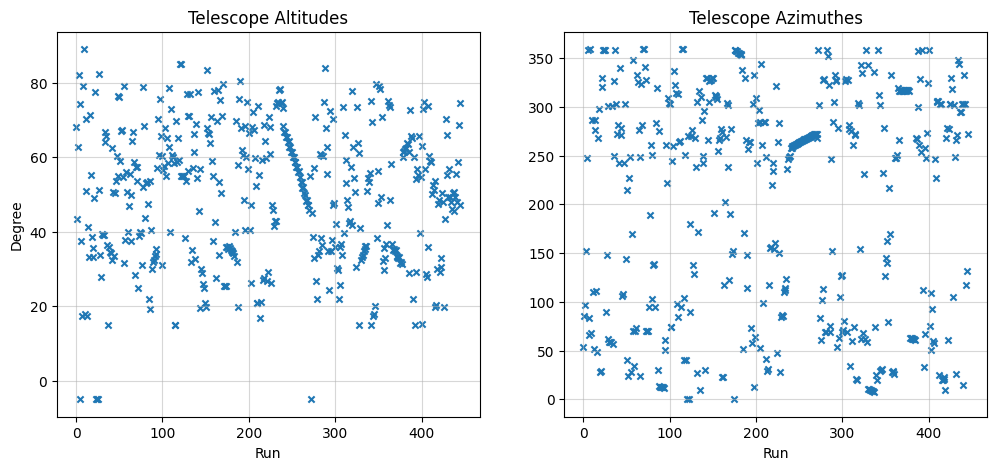

In [8]:
print(f"There are {len(run_numbers)} winter runs with small changes in telescope direction ")
altitudes = []
azimuthes = []

for key,item in run_numbers.items():
   #print(round(float(item.split(',')[0]),2),round(float(item.split(',')[1]),2))
   altitudes.append(round(float(item.split(',')[0]),2))
   azimuthes.append(round(float(item.split(',')[1]),2))

runs = [i for i in range(len(altitudes))]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)
axs[0].scatter(runs,altitudes, s = 20, marker = 'x')
axs
axs[0].grid(alpha = 0.5)
axs[1].scatter(runs,azimuthes, s = 20, marker = 'x')
axs[1].grid(alpha = 0.5)
axs[0].set_xlabel('Run')
axs[1].set_xlabel('Run')
axs[0].set_ylabel('Degree')
axs[0].set_title('Telescope Altitudes')
axs[1].set_title('Telescope Azimuthes')
#plt.scatter(runs,altitudes)
#plt.scatter(runs,azimuthes)



### Check time of each observation

In [ ]:
timestamp = 1.70673312e+09
dt_object = datetime.utcfromtimestamp(timestamp)

# Format the datetime object to a string in a readable format
formatted_time = dt_object.strftime('%Y-%m-%d %H:%M:%S')

formatted_time
for time in pd_hdf['time']:
    dt_object = datetime.utcfromtimestamp(time)
    formatted_time = dt_object.strftime('%Y-%m-%d %H:%M:%S')
    print(formatted_time)


2023-11-13 20:05:08
2023-11-13 20:16:39
2023-11-13 20:29:28
2023-11-13 20:41:16
2023-11-13 20:48:43
2023-11-13 20:59:11
2023-11-13 21:11:20
2023-11-13 21:18:42
2023-11-13 21:35:31
2023-11-13 21:48:27
2023-11-13 22:06:05
2023-11-13 22:49:54
2023-11-13 22:53:24
2023-11-13 23:00:45
2023-11-13 23:11:34
2023-11-13 23:24:01
2023-11-13 23:44:26
2023-11-14 00:04:48
2023-11-14 00:25:13
2023-11-14 00:45:36
2023-11-14 01:16:32
2023-11-14 01:46:50
2023-11-14 02:07:09
2023-11-14 02:27:32
2023-11-14 02:47:55
2023-11-14 02:58:40
2023-11-14 03:11:31
2023-11-14 03:31:04
2023-11-14 04:02:01
2023-11-14 04:14:37
2023-11-14 04:24:50
2023-11-14 04:30:34
2023-11-14 04:42:57
2023-11-14 05:02:59
2023-11-14 05:20:36
2023-11-14 05:42:57
2023-11-14 06:02:22


In [ ]:
altitudes = []
for i,item in enumerate(pd_hdf['mean_altitude']):
    altitudes.append(np.rad2deg(item))
    #print(f"for run number {pd_hdf['runnumber'][i]} the difference in altitude during run is {np.rad2deg(abs(pd_hdf['min_altitude'][i] - pd_hdf['max_altitude'][i]))} degrees")

azimuthes = []
for i,item in enumerate(pd_hdf['mean_altitude']):
    azimuthes.append(np.rad2deg(item))
    #print(f"for run number {pd_hdf['runnumber'][i]} the difference in altitude during run is {np.rad2deg(abs(pd_hdf['min_azimuth'][i] - pd_hdf['max_azimuth'][i]))} degrees")

In [ ]:
log_file_path = '/Users/vdk/muons2024/DL1_datacheck_20240131.log'

with open(log_file_path, 'r') as file:
    print_next_line = False
    for line in file:
        if print_next_line:
            print(line.strip())  # Print the next line
            print_next_line = False
        elif line.startswith('Anomalies'):
            print(line.strip())
            print_next_line = True
        

Anomalies in Interleaved pedestals rate (Hz):
Run 16445, Jan 31 2024 20:31:57:
Anomalies in Interleaved flat field rate (Hz):
Run 16445, Jan 31 2024 20:31:57:
Anomalies in Cosmics rate (/s):
None
Anomalies in Contained mu-rings rate (/s):
None
Anomalies in telescope efficiency from mu-rings:
Run 16445, Jan 31 2024 20:31:57:
Anomalies in muon ring width (deg):
None
Anomalies in mean muon ring intensity (p.e.):
None
Anomalies in HG global peak sample id (mean&RMS):
None
Anomalies in Fraction of pedestals surviving cleaning:
None
Anomalies in Cam-averaged FF Q (pe/pixel):
None
Anomalies in Cam-averaged FF Q std dev (pe/pixel):
None
Anomalies in Cam-averaged FF time (ns):
None
Anomalies in Cam-averaged FF time std dev (ns):
None
Anomalies in Cam-averaged FF rel. pix t std dev (ns):
None
Anomalies in Camera-averaged rate of >30pe pulses (/s):
None


In [ ]:
log_file_path = '/Users/vdk/muons2024/DL1_datacheck_20240131.log'

with open(log_file_path, 'r') as file:
    for line in file:
        print(line.strip())

_________________________________________________

WARNINGS relative to the quality of the data:

Anomalies in Interleaved pedestals rate (Hz):
Run 16445, Jan 31 2024 20:31:57:
Interleaved pedestals rate (Hz): 90.46 (too low)

Anomalies in Interleaved flat field rate (Hz):
Run 16445, Jan 31 2024 20:31:57:
Interleaved flat field rate (Hz): 90.09 (too low)

Anomalies in Cosmics rate (/s):
None

Anomalies in Contained mu-rings rate (/s):
None

Pedestal standard deviation, anomalous pixels:

Flat-Field mean charge, anomalous pixels:

Flat-Field mean relative time, anomalous pixels:
id 327 ([-3, 3, 1]) too low in 6 of 6 runs
id  1201 ([6, -12, 5]) too high in 5 of 6 runs
id  1269 ([-3, 13, 6]) too high in 6 of 6 runs
id  1394 ([-3, 13, 5]) too high in 6 of 6 runs

Flat-Field rel. time std dev, anomalous pixels:
id  449 ([-3, -7, 7]) too high in 6 of 6 runs
id  1051 ([4, 10, 7]) too high in 6 of 6 runs

Cosmics, rate of >30pe pulses, anomalous pixels:
id  5 ([0, 0, 2]) too high in 5 of 6 run

In [ ]:


log_file_path = '/Users/vdk/muons2024/DL1_datacheck_20240109.log'

with open(log_file_path, 'r') as file:
    for line in file:
        print(line.strip())

Run 16273 had 2 subruns with no valid muon rings!
Run 16278 had 2 subruns with no valid muon rings!
Run 16283 had 1 subruns with no valid muon rings!
_________________________________________________

WARNINGS relative to the quality of the data:

Anomalies in Interleaved pedestals rate (Hz):
None

Anomalies in Interleaved flat field rate (Hz):
None

Anomalies in Cosmics rate (/s):
Run 16289, Jan 10 2024 03:27:18:
Cosmics rate (/s): 7064.82 (too high)

Anomalies in Contained mu-rings rate (/s):
None

Pedestal standard deviation, anomalous pixels:

Flat-Field mean charge, anomalous pixels:
id 543 ([-4, 4, 5]) too low in 15 of 23 runs
id 596 ([1, -9, 4]) too low in 17 of 23 runs
id 1023 ([-6, 8, 3]) too low in 23 of 23 runs

Flat-Field mean relative time, anomalous pixels:
id  285 ([3, 5, 1]) too high in 23 of 23 runs
id  1269 ([-3, 13, 6]) too high in 23 of 23 runs
id  1394 ([-3, 13, 5]) too high in 23 of 23 runs

Flat-Field rel. time std dev, anomalous pixels:
id  449 ([-3, -7, 7]) too

### Perform all quality cuts on datacheck

In [10]:

# Specify the directory you want to start from
#root_dir = '/Users/vdk/muons2024/datacheck_v0.10/'
root_dir = '/Users/vdk/muons2024/v0.9/'

# Pattern to match all items in root_dir that are directories
pattern = os.path.join(root_dir, '*/')
optical_eff = {}
num_cosmic = {}
elapsed_time = {}
date = {}
mu_width = {}
mu_number = []


for dir_path in glob.glob(pattern):
    # Choose only winter
    #if dir_path[-5:-3] in ['11','12', '01', '02','03', '04']:
    if True:
        dl1_file = dir_path+f'DL1_datacheck_{dir_path[-9:-1]}.h5'
        print(f"reading {dl1_file}")
        pd_hdf = pd.read_hdf(dl1_file, 'runsummary/table')
        pd_hdf_cosmic = pd.read_hdf(dl1_file, 'cosmics/table')
        for i,item in enumerate(pd_hdf['mean_altitude']):
            # Choose only narrow FoV
            # if (np.rad2deg(abs(pd_hdf['min_altitude'][i] - pd_hdf['max_altitude'][i])) <= 1) and \
            #    (np.rad2deg(abs(pd_hdf['min_azimuth'][i] - pd_hdf['max_azimuth'][i])) <= 1):
            if True:
                if pd_hdf['mu_effi_mean'][i] < 0.3:
                    #num_cosmic[int(pd_hdf['runnumber'][i])] = (pd_hdf['num_cosmics'][i])
                    num_cosmic[pd_hdf['runnumber'][i]] = pd_hdf['num_cosmics'][i]
                    elapsed_time[int(pd_hdf['runnumber'][i])] = (pd_hdf['elapsed_time'][i])
                    date[int(pd_hdf['runnumber'][i])] = (pd_hdf['time'][i])
                    optical_eff[int(pd_hdf['runnumber'][i])] = (pd_hdf['mu_effi_mean'][i])
                    mu_width[int(pd_hdf['runnumber'][i])] = (pd_hdf['mu_width_mean'][i])
                    mu_number.append(pd_hdf['num_contained_mu_rings'][i])
        #print(dir_path+f'DL1_datacheck_{dir_path[-9:-1]}.h5')


reading /Users/vdk/muons2024/v0.9/20230618/DL1_datacheck_20230618.h5
reading /Users/vdk/muons2024/v0.9/20210811/DL1_datacheck_20210811.h5
reading /Users/vdk/muons2024/v0.9/20220228/DL1_datacheck_20220228.h5
reading /Users/vdk/muons2024/v0.9/20230415/DL1_datacheck_20230415.h5
reading /Users/vdk/muons2024/v0.9/20221103/DL1_datacheck_20221103.h5
reading /Users/vdk/muons2024/v0.9/20200610/DL1_datacheck_20200610.h5
reading /Users/vdk/muons2024/v0.9/20210816/DL1_datacheck_20210816.h5
reading /Users/vdk/muons2024/v0.9/20220210/DL1_datacheck_20220210.h5
reading /Users/vdk/muons2024/v0.9/20221104/DL1_datacheck_20221104.h5
reading /Users/vdk/muons2024/v0.9/20230620/DL1_datacheck_20230620.h5
reading /Users/vdk/muons2024/v0.9/20230412/DL1_datacheck_20230412.h5
reading /Users/vdk/muons2024/v0.9/20210829/DL1_datacheck_20210829.h5
reading /Users/vdk/muons2024/v0.9/20230616/DL1_datacheck_20230616.h5
reading /Users/vdk/muons2024/v0.9/20210211/DL1_datacheck_20210211.h5
reading /Users/vdk/muons2024/v0.9/

Mean value of the array = 4980552.955288842 
Standard deviation = 2530748.183495463


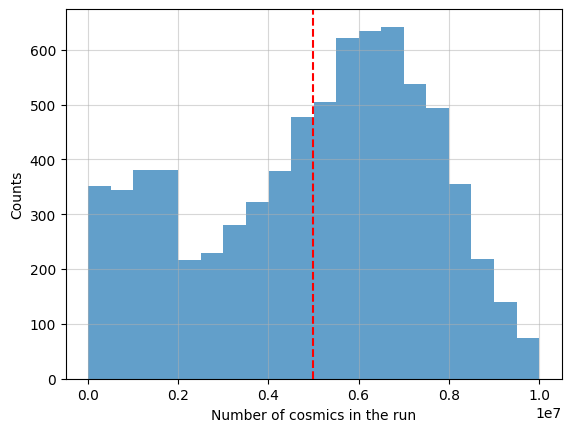

In [11]:
num = [item for key,item in num_cosmic.items()]
usefull_func.hist_wo_outliers(num,outlier_value=10000000,bin_number=20,xlabel='Number of cosmics in the run')

Mean value of the array = 2469.0826700898588 
Standard deviation = 1211.2561800057465


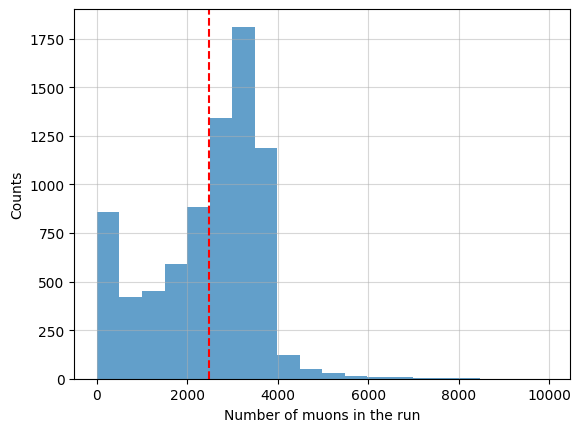

In [13]:
usefull_func.hist_wo_outliers(mu_number,outlier_value=10000,bin_number=20,xlabel='Number of muons in the run')

Text(0, 0.5, 'Optical Efficiency')

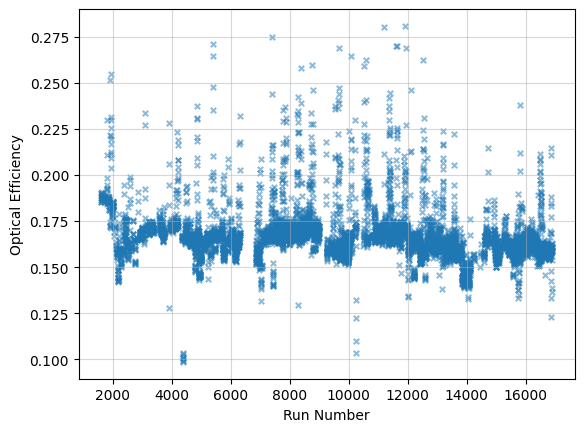

In [20]:
sorted_dict = {key: optical_eff[key] for key in sorted(optical_eff)}
runs = [key for key in sorted_dict.keys()]
effs = [sorted_dict[key] for key in sorted_dict.keys()]
plt.scatter(runs, effs, marker = 'x', s = 15, alpha = 0.5)
plt.grid(alpha = 0.5)
plt.xlabel('Run Number')
plt.ylabel('Optical Efficiency')

In [16]:
len(runs)

7800

Text(0.5, 1.0, 'Optical Efficiency')

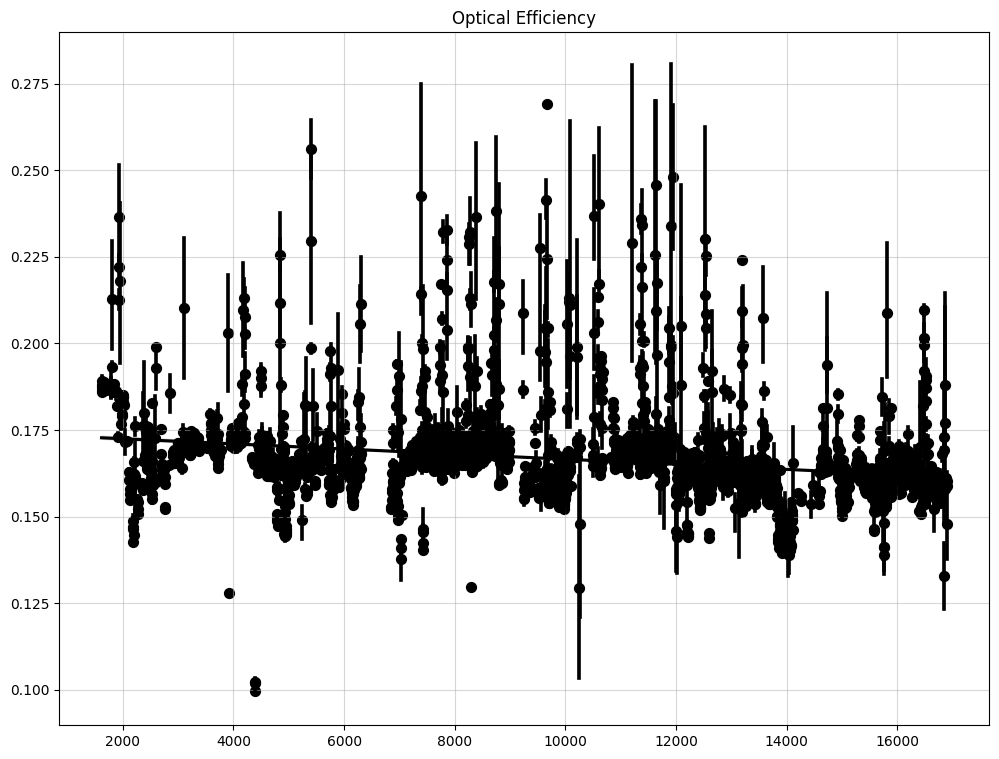

In [21]:
plt.figure(figsize = (12,9))
sns.regplot(x = runs, y = effs, x_bins=3000, color = 'k', label = 'Real Data')
plt.grid(alpha = 0.5)
plt.title("Optical Efficiency")

In [28]:

# Specify the directory you want to start from
root_dir = '/Users/vdk/muons2024/datacheck_v0.10/'
root_dir = '/Users/vdk/muons2024/v0.9/'

# Pattern to match all items in root_dir that are directories
pattern = os.path.join(root_dir, '*/')
optical_eff = {}
num_cosmic = {}
elapsed_time = {}
date = {}
mu_width = {}
mu_number = []
altitude = {}
azimuth = {}
list_of_dl1_files = []

for dir_path in glob.glob(pattern):
    # Choose only winter
    if dir_path[-5:-3] in ['11','12', '01', '02','03', '04']:
        dl1_file = dir_path+f'DL1_datacheck_{dir_path[-9:-1]}.h5'
        print(f"reading {dl1_file}")
        pd_hdf = pd.read_hdf(dl1_file, 'runsummary/table')
        pd_hdf_cosmic = pd.read_hdf(dl1_file, 'cosmics/table')
        for i,item in enumerate(pd_hdf['mean_altitude']):
            # Choose only narrow FoV
            if (np.rad2deg(abs(pd_hdf['min_altitude'][i] - pd_hdf['max_altitude'][i])) <= 1) and \
               (np.rad2deg(abs(pd_hdf['min_azimuth'][i] - pd_hdf['max_azimuth'][i])) <= 1):
                if pd_hdf['mu_effi_mean'][i] < 0.3:
                    if pd_hdf['num_contained_mu_rings'][i] < 3500 and pd_hdf['num_contained_mu_rings'][i] > 1500: 
                        if pd_hdf['num_cosmics'][i] < 10000000 and pd_hdf['num_cosmics'][i] > 3000000:
                            if (pd_hdf['elapsed_time'][i]) > 900:
                                list_of_dl1_files.append(dl1_file)
                                optical_eff[int(pd_hdf['runnumber'][i])] = (pd_hdf['mu_effi_mean'][i])
                                mu_width[int(pd_hdf['runnumber'][i])] = (pd_hdf['mu_width_mean'][i])
                                mu_number.append(pd_hdf['num_contained_mu_rings'][i])


reading /Users/vdk/muons2024/v0.9/20220228/DL1_datacheck_20220228.h5
reading /Users/vdk/muons2024/v0.9/20230415/DL1_datacheck_20230415.h5
reading /Users/vdk/muons2024/v0.9/20221103/DL1_datacheck_20221103.h5
reading /Users/vdk/muons2024/v0.9/20220210/DL1_datacheck_20220210.h5
reading /Users/vdk/muons2024/v0.9/20221104/DL1_datacheck_20221104.h5
reading /Users/vdk/muons2024/v0.9/20230412/DL1_datacheck_20230412.h5
reading /Users/vdk/muons2024/v0.9/20210211/DL1_datacheck_20210211.h5
reading /Users/vdk/muons2024/v0.9/20230424/DL1_datacheck_20230424.h5
reading /Users/vdk/muons2024/v0.9/20230423/DL1_datacheck_20230423.h5
reading /Users/vdk/muons2024/v0.9/20210216/DL1_datacheck_20210216.h5
reading /Users/vdk/muons2024/v0.9/20220423/DL1_datacheck_20220423.h5
reading /Users/vdk/muons2024/v0.9/20230226/DL1_datacheck_20230226.h5
reading /Users/vdk/muons2024/v0.9/20210413/DL1_datacheck_20210413.h5
reading /Users/vdk/muons2024/v0.9/20230219/DL1_datacheck_20230219.h5
reading /Users/vdk/muons2024/v0.9/

In [36]:
for file in list_of_dl1_files:
    pd_hdf = pd.read_hdf(file, 'runsummary/table')
    #pd_hdf_cosmic = pd.read_hdf(dl1_file, 'cosmics/table')
    for key,time in enumerate(pd_hdf['time']):
        dt_object = datetime.utcfromtimestamp(time)
        formatted_time = dt_object.strftime('%Y-%m-%d %H:%M:%S')
        print(f"for run {pd_hdf['runnumber'][key]} the date is {formatted_time}\n")

for run 7465 the date is 2022-03-25 21:58:58

for run 7466 the date is 2022-03-25 22:11:28

for run 7467 the date is 2022-03-25 22:36:15

for run 7468 the date is 2022-03-25 22:51:13

for run 7469 the date is 2022-03-25 23:06:50

for run 7470 the date is 2022-03-25 23:21:53

for run 7471 the date is 2022-03-25 23:36:45

for run 7472 the date is 2022-03-25 23:50:11

for run 7473 the date is 2022-03-26 00:54:58

for run 7474 the date is 2022-03-26 01:10:55

for run 7475 the date is 2022-03-26 01:24:52

for run 7476 the date is 2022-03-26 01:43:30

for run 7477 the date is 2022-03-26 02:04:07

for run 7478 the date is 2022-03-26 02:24:10

for run 7479 the date is 2022-03-26 02:44:19

for run 7480 the date is 2022-03-26 03:04:15

for run 7481 the date is 2022-03-26 03:16:34

for run 7482 the date is 2022-03-26 03:23:01

for run 7483 the date is 2022-03-26 03:37:36

for run 7484 the date is 2022-03-26 03:57:37

for run 7485 the date is 2022-03-26 04:18:03

for run 7486 the date is 2022-03-2

In [48]:
for file in list_of_dl1_files:
    pd_hdf = pd.read_hdf(file, 'runsummary/table')
    print(f"treating {file}")
    for i,item in enumerate(pd_hdf['mean_altitude']):
        if (np.rad2deg(abs(pd_hdf['min_altitude'][i] - pd_hdf['max_altitude'][i])) <= 1) and \
            (np.rad2deg(abs(pd_hdf['min_azimuth'][i] - pd_hdf['max_azimuth'][i])) <= 1):
                print(f"for run {pd_hdf['runnumber'][i]} we have altitude = {np.rad2deg(item)} and azimuth = {np.rad2deg(pd_hdf['mean_azimuth'][i])} and optical efficiency {pd_hdf['mu_effi_mean'][i]}")

treating /Users/vdk/muons2024/v0.9/20220325/DL1_datacheck_20220325.h5
for run 7466 we have altitude = 40.4700920848054 and azimuth = 275.0883833068864 and optical efficiency 0.16811112733179157
for run 7476 we have altitude = 30.069214303602955 and azimuth = 13.169831706302235 and optical efficiency 0.1636314710271324
for run 7477 we have altitude = 31.884189543398218 and azimuth = 12.894363845734937 and optical efficiency 0.16448451834795053
for run 7478 we have altitude = 32.367421824623946 and azimuth = 12.253340110713772 and optical efficiency 0.16451794942694778
for run 7479 we have altitude = 33.56459551049551 and azimuth = 12.793154433518554 and optical efficiency 0.164456311324417
for run 7480 we have altitude = 33.98641963516475 and azimuth = 12.074804486913974 and optical efficiency 0.16518075169674307
for run 7481 we have altitude = 35.25106615763402 and azimuth = 11.299781725365932 and optical efficiency 0.16472553686992653
for run 7482 we have altitude = 57.21868586876684 

In [50]:
set(list_of_dl1_files)

{'/Users/vdk/muons2024/v0.9/20210416/DL1_datacheck_20210416.h5',
 '/Users/vdk/muons2024/v0.9/20220325/DL1_datacheck_20220325.h5',
 '/Users/vdk/muons2024/v0.9/20230328/DL1_datacheck_20230328.h5',
 '/Users/vdk/muons2024/v0.9/20231110/DL1_datacheck_20231110.h5',
 '/Users/vdk/muons2024/v0.9/20231113/DL1_datacheck_20231113.h5'}

Text(0, 0.5, 'Optical Efficiency')

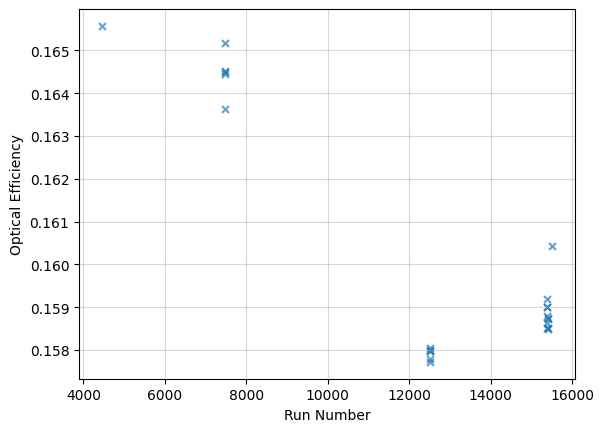

In [31]:
sorted_dict = {key: optical_eff[key] for key in sorted(optical_eff)}
runs = [key for key in sorted_dict.keys()]
effs = [sorted_dict[key] for key in sorted_dict.keys()]
plt.scatter(runs, effs, marker = 'x', s = 25, alpha = 0.7)
plt.grid(alpha = 0.5)
plt.xlabel('Run Number')
plt.ylabel('Optical Efficiency')

Text(0.5, 1.0, 'Optical Efficiency')

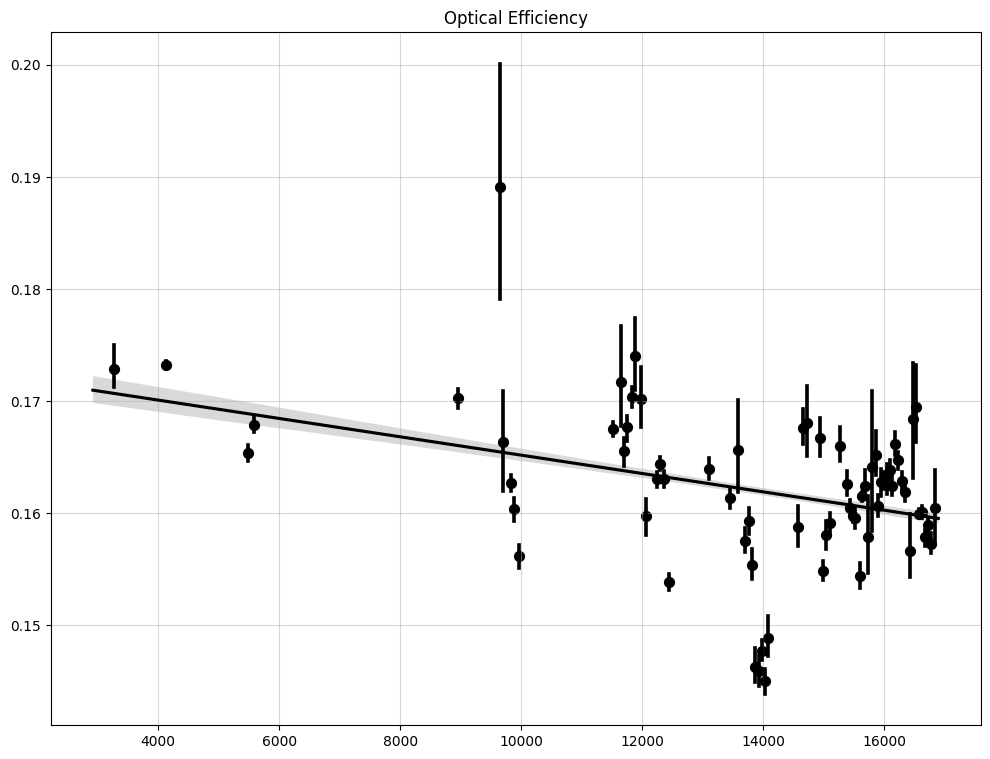

In [ ]:
plt.figure(figsize = (12,9))
sns.regplot(x = runs, y = effs, x_bins=70, color = 'k', label = 'Real Data')
plt.grid(alpha = 0.5)
plt.title("Optical Efficiency")

Text(0.5, 1.0, 'Optical Efficiency')

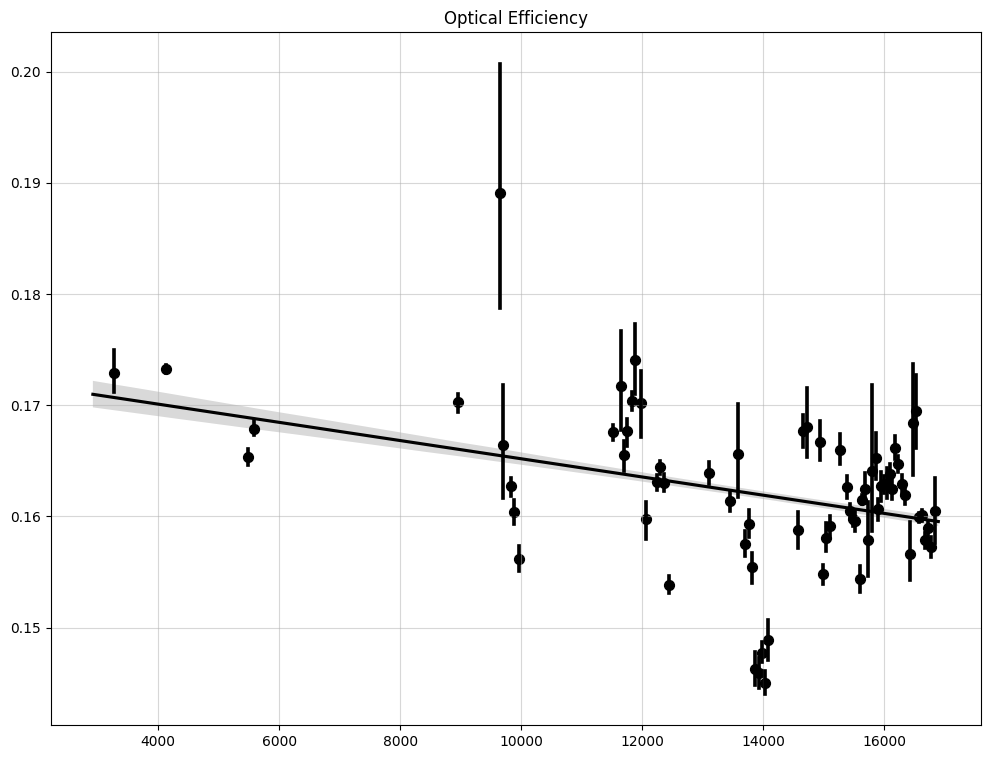

In [ ]:
plt.figure(figsize = (12,9))
sns.regplot(x = runs, y = effs, x_bins=70, color = 'k', label = 'Real Data')
plt.grid(alpha = 0.5)
plt.title("Optical Efficiency")

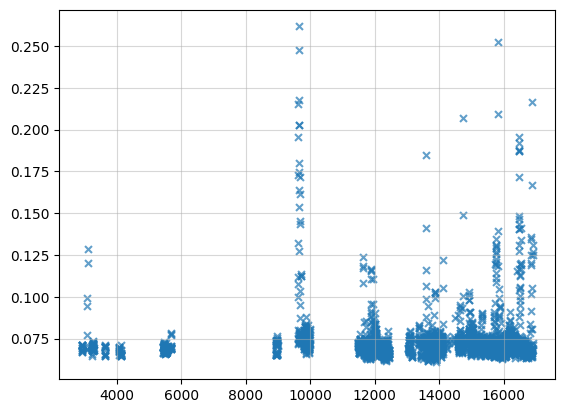

In [ ]:
sorted_dict = {key: mu_width[key] for key in sorted(mu_width)}
runs = [key for key in sorted_dict.keys()]
mu_width = [sorted_dict[key] for key in sorted_dict.keys()]
plt.scatter(runs, mu_width, marker = 'x', s = 25, alpha = 0.7)
plt.grid(alpha = 0.5)

Text(0.5, 1.0, 'Muon Width')

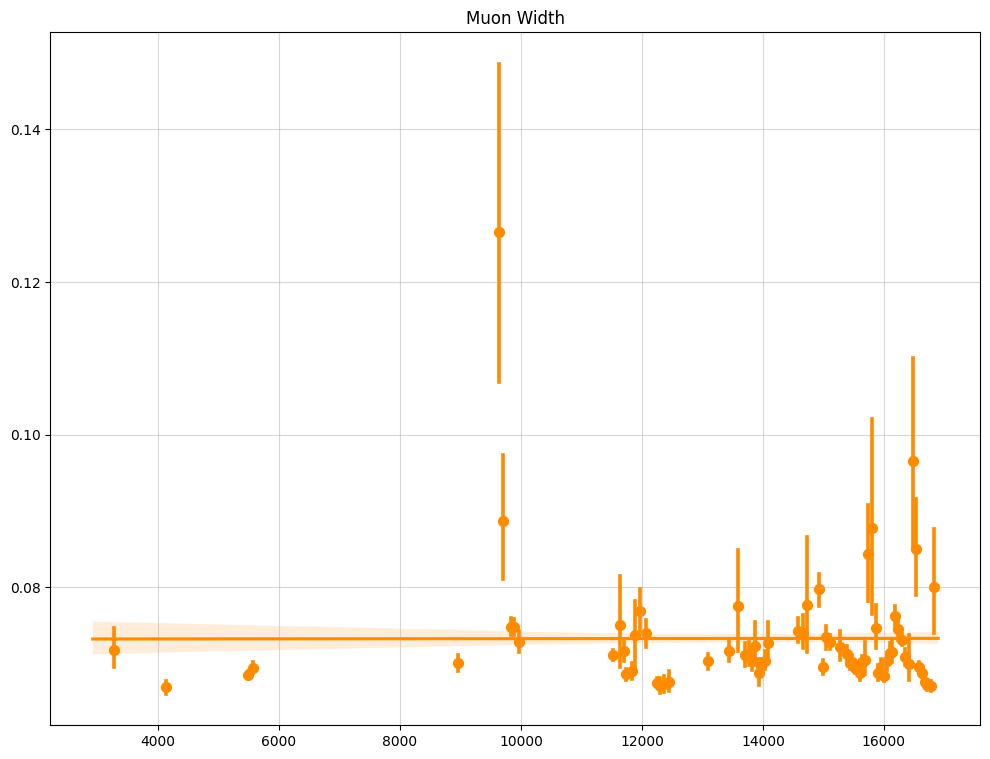

In [ ]:
plt.figure(figsize = (12,9))
sns.regplot(x = runs, y = mu_width, x_bins=70, color = 'darkorange', label = 'Real Data')
plt.grid(alpha = 0.5)
plt.title("Muon Width")

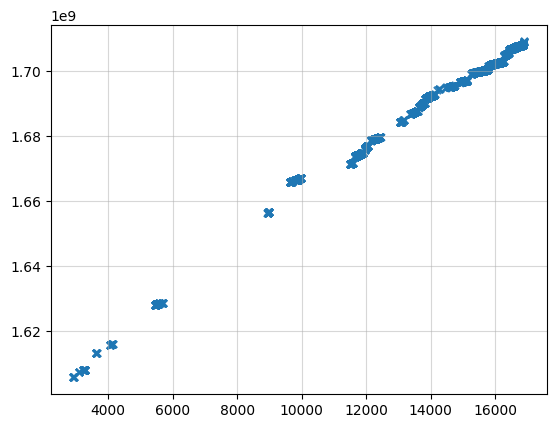

In [ ]:
sorted_dict = {key: date[key] for key in sorted(date)}
runs = [key for key in sorted_dict.keys()]
new_date = [sorted_dict[key] for key in sorted_dict.keys()]
plt.scatter(runs, new_date, marker = 'x', s = 25, alpha = 0.7)
plt.grid(alpha = 0.5)

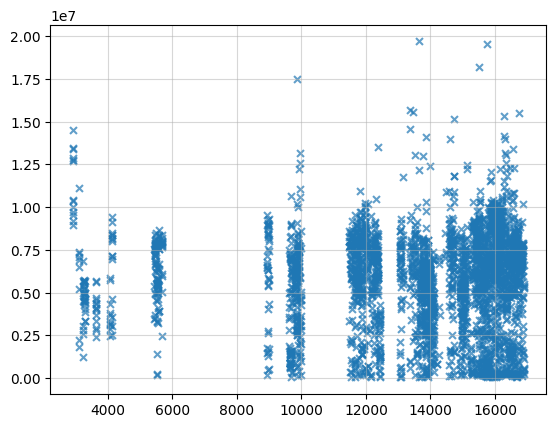

In [ ]:
sorted_dict = {key: num_cosmic[key] for key in sorted(num_cosmic)}
runs = [key for key in sorted_dict.keys()]
new_num_cosmic = [sorted_dict[key] for key in sorted_dict.keys()]
plt.scatter(runs, new_num_cosmic, marker = 'x', s = 25, alpha = 0.7)
plt.grid(alpha = 0.5)

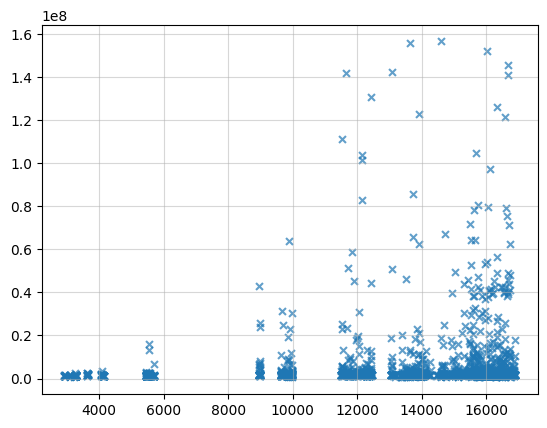

In [ ]:
sorted_cosmic = {key: date[key] for key in sorted(date)}
runs = [key for key in sorted_cosmic.keys()]
sorted_elapsed = {key: elapsed_time[key] for key in sorted(elapsed_time)}
runs_elapsed = [key for key in sorted_elapsed.keys()]
new_cosmic = np.array([sorted_cosmic[key] for key in sorted_cosmic.keys()])
new_elapsed = np.array([sorted_elapsed[key] for key in sorted_elapsed.keys()])
cosmic_rate = new_cosmic/new_elapsed
plt.scatter(runs, cosmic_rate, marker = 'x', s = 25, alpha = 0.7)
plt.grid(alpha = 0.5)

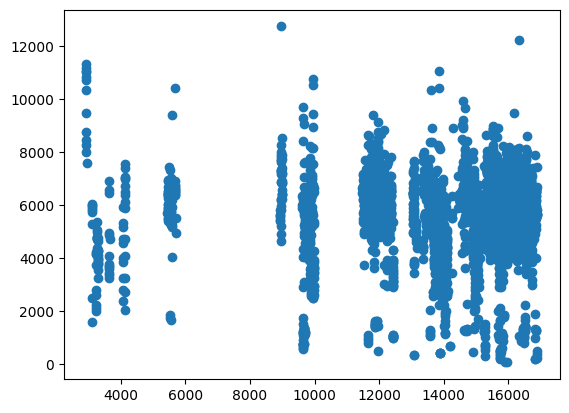

In [ ]:
cosmic_rate = []
x_runs = []
for key,item in num_cosmic.items():
    x_runs.append(key)
    cosmic_rate.append(item/elapsed_time[key])
    
plt.scatter(x_runs, cosmic_rate)
    

In [ ]:
for time in elapsed_time:
    print(time/60)

94.66666666666667
94.68333333333334
94.7
94.71666666666667
94.73333333333333
94.75
94.76666666666667
94.78333333333333
94.8
94.81666666666666
94.83333333333333
94.85
94.86666666666666
94.88333333333334
222.75
222.83333333333334
222.85
222.86666666666667
222.88333333333333
222.9
222.91666666666666
222.93333333333334
222.95
222.96666666666667
222.98333333333332
223.0
223.01666666666668
223.03333333333333
223.05
223.06666666666666
223.08333333333334
223.1
230.98333333333332
231.0
231.05
231.06666666666666
231.08333333333334
231.1
231.11666666666667
231.13333333333333
231.15
231.16666666666666
231.18333333333334
231.2
231.21666666666667
231.23333333333332
231.25
231.26666666666668
231.28333333333333
231.3
231.31666666666666
149.46666666666667
149.48333333333332
149.5
149.51666666666668
149.53333333333333
149.55
149.56666666666666
149.58333333333334
149.6
149.61666666666667
149.63333333333333
149.65
149.66666666666666
149.68333333333334
149.7
149.71666666666667
149.73333333333332
149.75
149

In [ ]:
from astropy.io import fits

# Path to your FITS file
fits_file_path = '/Users/vdk/muons2024/muons_LST-1.Run16869.0095.fits'


with fits.open(fits_file_path) as hdul:
    # hdul is a list-like collection of HDU (Header/Data Unit) objects.
    
    # Print the contents of the FITS file
    hdul.info()
    
    # Access the primary HDU (HDU 0)
    primary_hdu = hdul[1]
    
    # Access data and header of the primary HDU
    data = primary_hdu.data
    header = primary_hdu.header
    
    # Print header information
    print(header)
    


Filename: /Users/vdk/muons2024/muons_LST-1.Run16869.0095.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     54   70R x 23C   [K, D, K, E, E, D, D, D, D, L, D, D, D, D, D, D, D, D, D, K, D, K, K]   
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  169 / length of dimension 1                          NAXIS2  =                   70 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   23 / number of table fields                         TTYPE1  = 'event_id'                                      

In [ ]:
keys = [
    ('event_id', '>i8'), 
    ('event_time', '>f8'), 
    ('mc_energy', '>i8'), 
    ('ring_size', '>f4'), 
    ('size_outside', '>f4'), 
    ('ring_center_x', '>f8'), 
    ('ring_center_y', '>f8'), 
    ('ring_radius', '>f8'), 
    ('ring_width', '>f8'), 
    ('good_ring', 'i1'), 
    ('muon_efficiency', '>f8'), 
    ('ring_containment', '>f8'), 
    ('ring_completeness', '>f8'), 
    ('impact_parameter', '>f8'), 
    ('impact_x_array', '>f8'),
    ('impact_y_array', '>f8'), 
    ('radial_stdev', '>f8'), 
    ('radial_skewness', '>f8'), 
    ('radial_excess_kurtosis', '>f8'), 
    ('num_pixels_in_ring', '>i8'), 
    ('mean_pixel_charge_around_ring', '>f8'), 
    ('hg_peak_sample', '>i8'), 
    ('lg_peak_sample', '>i8')
]

for i, item in enumerate(data[0]):
    print(f"{keys[i][0]} = {item}")

event_id = 5682143
event_time = 1708318158.8799717
mc_energy = -1
ring_size = 2027.1221923828125
size_outside = 0.0
ring_center_x = -0.4045682406419627
ring_center_y = -0.7900726250720322
ring_radius = 1.1971463392595851
ring_width = 0.061038758321933576
good_ring = True
muon_efficiency = 0.16057668585387422
ring_containment = 1.0
ring_completeness = 0.5333333333333333
impact_parameter = 9.29424149090154
impact_x_array = 1.0319942737347951
impact_y_array = 9.236769603610034
radial_stdev = 0.05629116810444093
radial_skewness = 0.5506157515541137
radial_excess_kurtosis = 0.49785846282376456
num_pixels_in_ring = 484
mean_pixel_charge_around_ring = 0.2217838276033939
hg_peak_sample = 18
lg_peak_sample = 0


In [ ]:

EventSource